# Benchmarking

In [2]:
import numpy as np
import xarray as xr
from scipy import stats
import pandas as pd
import numba as nb
import dask
from datetime import datetime
import matplotlib.pyplot as plt
import awkward as ak
import functools

# xarray Dataset

In [32]:
path_gdp = '../data/process/gdp_v2.00.nc'
ds = xr.open_dataset(path_gdp)

In [33]:
ds

<xarray.Dataset>
Dimensions:                (traj: 17324, obs: 165754333)
Coordinates:
    ID                     (traj) int64 ...
    longitude              (obs) float32 ...
    latitude               (obs) float32 ...
    time                   (obs) datetime64[ns] ...
    ids                    (obs) int64 ...
Dimensions without coordinates: traj, obs
Data variables: (12/54)
    rowsize                (traj) int64 ...
    location_type          (traj) bool ...
    WMO                    (traj) int32 ...
    expno                  (traj) int32 ...
    deploy_date            (traj) datetime64[ns] ...
    deploy_lon             (traj) float32 ...
    ...                     ...
    err_sst                (obs) float32 ...
    err_sst1               (obs) float32 ...
    err_sst2               (obs) float32 ...
    flg_sst                (obs) int8 ...
    flg_sst1               (obs) int8 ...
    flg_sst2               (obs) int8 ...
Attributes: (12/15)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-02-02T15:57:04.179158
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    metadata_link:     https://www.aoml.noaa.gov/phod/dac/dirall.html
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot et al. (2022) to be submitted. Elipot et al. (2...
    summary:           Global Drifter Program hourly data

## Geographical binning of any variable (SST, velocity)

In [132]:
%%time

lon = np.linspace(-98, -78, 76)
lat = np.linspace(18, 31, 50)

ret = stats.binned_statistic_2d(ds.longitude, 
                                ds.latitude, 
                                ds.sst, 
                                statistic='mean', bins=[lon, lat])

CPU times: user 12.5 s, sys: 2.72 s, total: 15.2 s
Wall time: 16.6 s


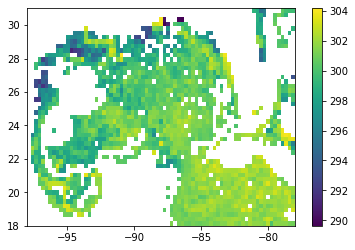

In [133]:
x_c = np.convolve(lon, [0.5, 0.5], mode='valid')
y_c = np.convolve(lat, [0.5, 0.5], mode='valid')
plt.pcolormesh(x_c, y_c, ret.statistic.T)
plt.colorbar()

## Extracting a given region

In [312]:
def retrieve_region(ds, lon: list = None, lat: list = None, time: list = None):
    '''

    :param lon:
    :param lat:
    :param time:
    :return:
    '''
    mask = np.ones(ds.dims['obs'], dtype='bool')

    if lon:  # TODO: deal with ranges across dateline
        mask &= (ds.coords['longitude'] >= lon[0]).values
        mask &= (ds.coords['longitude'] <= lon[1]).values

    if lat:
        mask &= (ds.coords['latitude'] >= lat[0]).values
        mask &= (ds.coords['latitude'] <= lat[1]).values

    if time:
        mask &= (ds.coords['time'] >= np.datetime64(time[0])).values
        mask &= (ds.coords['time'] <= np.datetime64(time[1])).values

    mask_id = np.in1d(ds.ID, np.unique(ds.ids[mask]))
    ds_subset = ds.isel(obs=np.where(mask)[0], traj=np.where(mask_id)[0])

    return ds_subset.compute(), mask

In [313]:
%%time

lon = [-98, -78]
lat = [18, 31]
day0 = "%sZ" % datetime(2015,1,1).isoformat()
day1 = "%sZ" % datetime(2020,12,31).isoformat()
time = [day0, day1]
ds_subset, m = retrieve_region(ds, lon, lat, time)

/var/folders/jh/92r7zqw159xbv25hk5fbrzgw0000gp/T/ipykernel_32465/2976316536.py:20: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  mask &= (ds.coords['time'] >= np.datetime64(time[0])).values
/var/folders/jh/92r7zqw159xbv25hk5fbrzgw0000gp/T/ipykernel_32465/2976316536.py:21: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  mask &= (ds.coords['time'] <= np.datetime64(time[1])).values


CPU times: user 1min 20s, sys: 10.6 s, total: 1min 31s
Wall time: 1min 37s


In [314]:
ds_subset

<xarray.Dataset>
Dimensions:                (traj: 202, obs: 316141)
Coordinates:
    ID                     (traj) int64 102539 102541 102542 ... 39629 89907
    longitude              (obs) float32 -87.51 -87.48 -87.44 ... -81.62 -81.6
    latitude               (obs) float32 29.42 29.42 29.41 ... 24.36 24.37 24.37
    time                   (obs) datetime64[ns] 2016-01-22T15:00:00 ... 2015-...
    ids                    (obs) int64 102539 102539 102539 ... 89907 89907
Dimensions without coordinates: traj, obs
Data variables: (12/54)
    rowsize                (traj) int64 1684 240 93 1460 ... 613 779 3835 92
    location_type          (traj) bool False False False ... False False False
    WMO                    (traj) int32 4200514 4300563 ... 4300570 6300547
    expno                  (traj) int32 5325 5325 5325 5325 ... 8325 8325 9325
    deploy_date            (traj) datetime64[ns] 2016-01-21 ... 2015-06-23
    deploy_lon             (traj) float32 -87.67 -83.68 -83.15 ... -88.42 -83.1
    ...                     ...
    err_sst                (obs) float32 0.051 0.049 0.049 ... 0.041 0.041 nan
    err_sst1               (obs) float32 0.121 0.083 0.059 ... 0.079 0.115 nan
    err_sst2               (obs) float32 0.124 0.104 0.083 ... 0.097 0.112 nan
    flg_sst                (obs) int8 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 0
    flg_sst1               (obs) int8 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 0
    flg_sst2               (obs) int8 5 5 5 5 2 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 0
Attributes: (12/15)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-02-02T15:57:04.179158
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    metadata_link:     https://www.aoml.noaa.gov/phod/dac/dirall.html
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot et al. (2022) to be submitted. Elipot et al. (2...
    summary:           Global Drifter Program hourly data

## Single statistics per trajectory

In [37]:
traj_idx = np.insert(np.cumsum(ds.rowsize.values), 0, 0)

In [343]:
%%time

stats_traj = np.zeros(ds.dims['traj'])
for i in range(0, ds.dims['traj']):
    stats_traj[i] = np.nanmean(ds.sst[traj_idx[i]:traj_idx[i+1]])

<timed exec>:3: RuntimeWarning: Mean of empty slice


CPU times: user 2.49 s, sys: 43.5 ms, total: 2.53 s
Wall time: 2.55 s


### if we preload the full vector

In [342]:
%%time

stats_traj = np.zeros(ds.dims['traj'])
sst = ds.sst.values
for i in range(0, ds.dims['traj']):
    stats_traj[i] = np.nanmean(sst[traj_idx[i]:traj_idx[i+1]])

<timed exec>:4: RuntimeWarning: Mean of empty slice


CPU times: user 568 ms, sys: 12.2 ms, total: 580 ms
Wall time: 582 ms


In [38]:
# those two functions do the same thing
# here simply to show the use of vectorize
@nb.jit
def fake_distance(lon1, lon2, lat1, lat2):
    d = np.zeros_like(lon1)
    for i in range(0, len(d)):
        d[i] = np.sqrt((lon1[i] - lon2[i])**2 + (lat1[i] - lat2[i])**2)
    return d

@nb.vectorize([nb.float64(nb.float32, nb.float32, nb.float32, nb.float32)])
def fake_distance_2(lon1, lon2, lat1, lat2):
    return np.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)

In [39]:
%%time

distance_traj = np.zeros(ds.dims['obs'])
lon_ds = ds.longitude.values
lat_ds = ds.latitude.values

for i in range(0, ds.dims['traj']):
    r = np.arange(traj_idx[i], traj_idx[i+1])
    distance_traj[r[:-1]] = fake_distance(
                                lon_ds[r[1:]], lon_ds[r[:-1]],
                                lat_ds[r[1:]], lat_ds[r[:-1]]
                            )

CPU times: user 1.07 s, sys: 440 ms, total: 1.51 s
Wall time: 1.8 s


In [40]:
%%time

distance_traj = np.zeros(ds.dims['obs'])
lon_ds = ds.longitude.values
lat_ds = ds.latitude.values

for i in range(0, ds.dims['traj']):
    r = np.arange(traj_idx[i], traj_idx[i+1])
    distance_traj[r[:-1]] = fake_distance_2(
                                lon_ds[r[1:]], lon_ds[r[:-1]],
                                lat_ds[r[1:]], lat_ds[r[:-1]]
                            )

CPU times: user 916 ms, sys: 250 ms, total: 1.17 s
Wall time: 1.19 s


In [80]:
del ds

# Using Awkward arrays

In [3]:
%%time
ds_ak = ak.from_parquet("../data/process/gdp_v2.00.parquet")

/Users/pmiron/miniforge3/envs/clouddrift/lib/python3.10/site-packages/awkward/operations/convert.py:1999: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/pmiron/miniforge3/envs/clouddrift/lib/python3.10/site-packages/awkward/operations/convert.py:2001: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < distutils.version.LooseVersion("2.0.0"):


CPU times: user 33.7 s, sys: 25.6 s, total: 59.3 s
Wall time: 22.8 s


In [4]:
ds_ak.longitude

<Array [[-17.7, -17.7, ... -30.3, -30.4]] type='17324 * var * float32'>

## Geographical binning of any variable (SST, velocity)

In [5]:
%%time

lon = np.linspace(-98, -78, 76)
lat = np.linspace(18, 31, 50)

ret = stats.binned_statistic_2d(ak.flatten(ds_ak.longitude, axis=1), 
                                ak.flatten(ds_ak.latitude, axis=1), 
                                ak.flatten(ds_ak.sst, axis=1), 
                                statistic='mean', bins=[lon, lat])

CPU times: user 13.5 s, sys: 3.13 s, total: 16.6 s
Wall time: 18.2 s


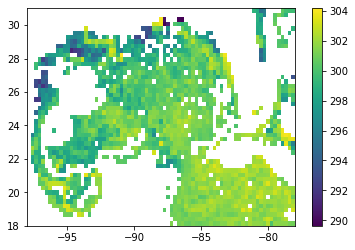

In [7]:
x_c = np.convolve(lon, [0.5, 0.5], mode='valid')
y_c = np.convolve(lat, [0.5, 0.5], mode='valid')
plt.pcolormesh(x_c, y_c, ret.statistic.T)
plt.colorbar()

## Extracting a given region

In [8]:
def retrieve_region_ak(ds, lon: list = None, lat: list = None, time: list = None):
    
    mask = functools.reduce(np.logical_and, 
                            (
                                ds.longitude > lon[0], 
                                ds.longitude < lon[1],
                                ds.latitude > lat[0],
                                ds.latitude < lat[1],
                                # TODO: add time to parquet
                                #ds_ak.time > day0,
                                #ds_ak.time < day1,
                            )
                           )
    
    keep = np.sum(mask == True, axis=1) > 0
    return ds[mask][keep]

In [9]:
%%time

lon = [-98, -78]
lat = [18, 31]
day0 = "%sZ" % datetime(2015,1,1).isoformat()
day1 = "%sZ" % datetime(2020,12,31).isoformat()
time = [day0, day1]
ds_subset_ak = retrieve_region_ak(ds_ak, lon, lat, time)

CPU times: user 1.59 s, sys: 1.04 s, total: 2.62 s
Wall time: 3.22 s


## Single statistic per trajectory

In [11]:
# not super useful.. but technically it should reduce the array

In [12]:
ak.mean(ds_ak.sst)

nan

In [13]:
# can loop trajectory and apply numpy operation

In [19]:
%%time
m = np.zeros(len(ds_ak.sst))
for i, s in enumerate(ds_ak.sst):
    m[i] = np.nanmean(s)

/Users/pmiron/miniforge3/envs/clouddrift/lib/python3.10/site-packages/awkward/_connect/_numpy.py:50: RuntimeWarning: Mean of empty slice
  out = func(*args, **kwargs)


CPU times: user 1.73 s, sys: 152 ms, total: 1.88 s
Wall time: 1.95 s


In [73]:
# this is 6x slower than the xarray version where I preallocate the array

In [65]:
%%time

d = fake_distance_2(
    ds_ak.longitude[:, 1:], ds_ak.longitude[:, :-1],
    ds_ak.latitude[:, 1:], ds_ak.latitude[:, :-1],
)

CPU times: user 1.4 s, sys: 4.42 s, total: 5.82 s
Wall time: 8 s


In [66]:
d

<Array [[0.0106, 0.0107, ... 0.0501, 0.0542]] type='17324 * var * float64'>

In [74]:
# Jim Pivarski helped me write this as an example
@nb.jit
def fill_fake_distance(out, longitude, latitude):
    i = 0
    for lon, lat in zip(longitude, latitude):
        out[i] = 0   # first one
        i += 1
        for j in range(len(lon) - 1):
            londiff = lon[j + 1] - lon[j]
            latdiff = lat[j + 1] - lat[j]
            fake = np.sqrt(londiff**2 + latdiff**2)
            out[i] = fake
            i += 1

In [76]:
%%time

out = np.empty(len(ds_ak.longitude.layout.content))
fill_fake_distance(out, ds_ak.longitude, ds_ak.latitude)
d = ak.Array(ak.layout.ListOffsetArray32(ak.layout.Index32(traj_idx), ak.layout.NumpyArray(out)))

CPU times: user 475 ms, sys: 172 ms, total: 647 ms
Wall time: 823 ms


In [77]:
d

<Array [[0, 0.0106, ... 0.0501, 0.0542]] type='17324 * var * float64'>

In [81]:
del ds_ak

# Pandas

In [4]:
%%time

ds = xr.open_dataset("../data/process/gdp_6h_v2.00.nc").drop_dims('traj')
df_6h = ds.to_dataframe()

CPU times: user 468 ms, sys: 1.65 s, total: 2.12 s
Wall time: 2.91 s


In [5]:
df_6h

,ve,vn,err_lat,err_lon,drogue_status,temp,err_temp,longitude,latitude,time,ids
obs,,,,,,,,,,,
0,-1.000000e+34,-1.000000e+34,0.006575,0.008130,True,17.381001,0.052832,-120.758003,33.542000,2011-10-28 06:00:00,101547
1,-1.817700e-01,-1.879900e-01,0.002265,0.002756,True,17.325001,0.045257,-120.805000,33.502998,2011-10-28 12:00:00,101547
2,-2.313400e-01,-1.601500e-01,0.001711,0.002188,True,17.379999,0.045252,-120.843002,33.469002,2011-10-28 18:00:00,101547
3,-2.790000e-01,-1.858700e-01,0.002075,0.002592,True,17.487000,0.045252,-120.912003,33.441002,2011-10-29 00:00:00,101547
4,-3.072400e-01,-1.984400e-01,0.002710,0.003170,True,17.389000,0.045296,-120.972000,33.396999,2011-10-29 06:00:00,101547
...,...,...,...,...,...,...,...,...,...,...,...
41205534,-3.240100e-01,3.060000e-02,0.051293,0.067139,False,27.573999,0.096737,174.018005,8.693000,2000-02-25 18:00:00,9945
41205535,-3.355600e-01,2.406000e-02,0.050043,0.065832,False,NaN,0.119503,173.953003,8.698000,2000-02-26 00:00:00,9945
41205536,-3.380900e-01,2.005000e-02,0.044179,0.057765,False,NaN,0.121840,173.886002,8.702000,2000-02-26 06:00:00,9945


In [3]:
%%time

df = pd.read_parquet("../data/process/gdp_v2.00_obs.parquet")

CPU times: user 11.1 s, sys: 16.5 s, total: 27.7 s
Wall time: 39.9 s


In [4]:
df.head()

,ve,vn,gap,err_lat,err_lon,err_ve,err_vn,drogue_status,sst,sst1,...,err_sst,err_sst1,err_sst2,flg_sst,flg_sst1,flg_sst2,longitude,latitude,time,ids
obs,,,,,,,,,,,,,,,,,,,,,
0,-0.0285,0.3101,2333.0,0.00116,0.00266,0.0997,0.0277,True,293.884003,293.907013,...,0.019,0.042,0.044,5,5,2,-17.74345,14.74677,2012-03-15 22:00:00,101143
1,0.0513,0.3423,5962.0,0.00062,0.00558,0.0779,0.0106,True,293.808990,293.899994,...,0.023,0.031,0.044,5,5,5,-17.74526,14.75717,2012-03-15 23:00:00,101143
2,0.0606,0.3439,5962.0,0.00091,0.00239,0.0650,0.0123,True,293.756989,293.885986,...,0.025,0.023,0.037,5,5,5,-17.74375,14.76780,2012-03-16 00:00:00,101143
3,0.1054,0.3137,7258.0,0.00215,0.00123,0.0212,0.0365,True,293.725006,293.868988,...,0.024,0.017,0.029,5,5,5,-17.74173,14.77795,2012-03-16 01:00:00,101143
4,0.1058,0.3183,7258.0,0.00409,0.00029,0.0203,0.0385,True,293.697998,293.850006,...,0.021,0.014,0.022,5,5,5,-17.73838,14.78923,2012-03-16 02:00:00,101143


## Geographical binning of any variable (SST, velocity)

In [5]:
%%time

lon = np.linspace(-98, -78, 76)
lat = np.linspace(18, 31, 50)

ret = stats.binned_statistic_2d(df.longitude, 
                                df.latitude, 
                                df.sst, 
                                statistic='mean', bins=[lon, lat])

CPU times: user 13.1 s, sys: 2.9 s, total: 16 s
Wall time: 20.6 s


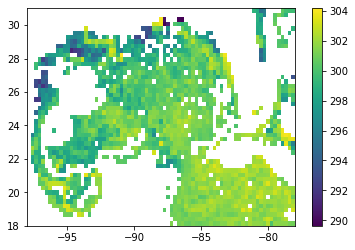

In [6]:
x_c = np.convolve(lon, [0.5, 0.5], mode='valid')
y_c = np.convolve(lat, [0.5, 0.5], mode='valid')
plt.pcolormesh(x_c, y_c, ret.statistic.T)
plt.colorbar()

## Extracting a given region

In [23]:
def retrieve_region_pd(df, lon: list = None, lat: list = None, time: list = None):
    mask = functools.reduce(np.logical_and, 
                            (
                                df.longitude > lon[0], 
                                df.longitude < lon[1],
                                df.latitude > lat[0],
                                df.latitude < lat[1],
                                df.time > day0,
                                df.time < day1,
                            )
                           )
    
    # this should work but crashes the kernel applying the where()
    return df.loc[mask]      

In [25]:
%%time

lon = [-98, -78]
lat = [18, 31]
day0 = datetime(2015,1,1)
day1 = datetime(2020,12,31)
time = [day0, day1]
df_subset = retrieve_region_pd(df, lon, lat, time)

CPU times: user 1.46 s, sys: 2 s, total: 3.46 s
Wall time: 8.32 s


In [26]:
df_subset

,ve,vn,gap,err_lat,err_lon,err_ve,err_vn,drogue_status,sst,sst1,...,err_sst,err_sst1,err_sst2,flg_sst,flg_sst1,flg_sst2,longitude,latitude,time,ids
obs,,,,,,,,,,,,,,,,,,,,,
2909297,0.9168,-0.2091,6134.0,0.00158,0.00314,0.0378,0.0279,False,294.431000,294.895996,...,0.051,0.121,0.124,5,5,5,-87.514198,29.422810,2016-01-22 15:00:00,102539
2909298,0.9245,-0.2115,5789.0,0.00100,0.00277,0.0409,0.0278,False,294.386993,294.851013,...,0.049,0.083,0.104,5,5,5,-87.480820,29.416330,2016-01-22 16:00:00,102539
2909299,0.9377,-0.2107,5789.0,0.00260,0.00362,0.0383,0.0340,False,294.428986,294.808014,...,0.049,0.059,0.083,5,5,5,-87.443893,29.409849,2016-01-22 17:00:00,102539
2909300,0.8747,-0.2839,4061.0,0.00186,0.00314,0.0517,0.0283,False,294.541992,294.774994,...,0.048,0.044,0.064,5,5,5,-87.410980,29.401060,2016-01-22 18:00:00,102539
2909301,0.8516,-0.2739,5616.0,0.00128,0.00126,0.0115,0.0223,False,294.700012,294.752014,...,0.047,0.035,0.052,5,5,2,-87.378487,29.391870,2016-01-22 19:00:00,102539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157080441,0.4280,0.1676,3456.0,0.00365,0.00092,0.0155,0.0779,False,302.460999,302.766998,...,0.045,0.040,0.061,5,5,5,-81.666702,24.349239,2015-06-27 10:00:00,89907
157080442,0.4708,0.1784,5875.0,0.00177,0.00115,0.0340,0.0190,False,302.457001,302.777008,...,0.044,0.055,0.078,5,5,5,-81.651039,24.354561,2015-06-27 11:00:00,89907
157080443,0.4730,0.1772,5875.0,0.00046,0.00226,0.0374,0.0150,False,302.446991,302.808014,...,0.041,0.079,0.097,5,5,5,-81.635109,24.360661,2015-06-27 12:00:00,89907


## Single statistic per trajectory

In [142]:
# mean of all values of a certain trajectory
df[df['ids'] == 2578].mean()

/var/folders/jh/92r7zqw159xbv25hk5fbrzgw0000gp/T/ipykernel_41167/1140139009.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df[df['ids'] == 2578].mean()


ve                  0.016376
vn                 -0.037559
gap              6657.133789
err_lat             0.002503
err_lon             0.004255
err_ve              0.000000
err_vn              0.000000
drogue_status       0.995912
sst               285.425415
sst1              285.427887
sst2               -0.002436
err_sst             0.059197
err_sst1            0.020229
err_sst2            0.053005
flg_sst             4.917072
flg_sst1            4.927000
flg_sst2            4.338135
longitude         -51.361526
latitude           43.663841
ids              2578.000000
dtype: float64

In [34]:
%%time

df.groupby("ids").sst.mean()

CPU times: user 1.82 s, sys: 1.6 s, total: 3.42 s
Wall time: 4.47 s


ids
2578        285.425415
2582        283.875000
2583               NaN
2592        275.799561
2612        280.003937
               ...    
68249260    284.647736
68310100    293.225861
68313240    288.159882
68318210    287.978882
68604340    300.194458
Name: sst, Length: 17324, dtype: float32

In [50]:
%%time
a = df.groupby("ids").sst.apply(lambda x: np.nanmax(x) - np.nanmin(x))

<timed exec>:1: RuntimeWarning: All-NaN axis encountered


CPU times: user 4.5 s, sys: 2.52 s, total: 7.03 s
Wall time: 8.58 s


In [52]:
a

ids
2578        32.203003
2582        25.518982
2583              NaN
2592        12.787994
2612        27.608002
              ...    
68249260     1.071014
68310100     6.352020
68313240     4.380005
68318210     4.044983
68604340     0.925018
Name: sst, Length: 17324, dtype: float32

In [70]:
a[68249260]

1.0710144

In [71]:
np.where(a.index == 68249260)

(array([17319]),)

In [72]:
a.iloc[17319]

1.0710144

In [73]:
%%time
b = df.groupby("ids").ve.apply(lambda x: np.fft.fft(x))

CPU times: user 11.5 s, sys: 3.25 s, total: 14.7 s
Wall time: 17.7 s


In [74]:
b

ids
2578        [(84.12539982477031-8.659739592076221e-15j), (...
2582        [(-46.70039948452904-3.552713678800501e-15j), ...
2583        [(14.370900012560014+0j), (-5.098882772966382+...
2592        [(-33.94209999701707+0j), (11.234026564207607+...
2612        [(-14.81750007714436+0j), (0.4535426457739284-...
                                  ...                        
68249260    [(5.921700036735273+8.881784197001252e-16j), (...
68310100    [(-90.23049979577625-6.661338147750939e-16j), ...
68313240    [(-9.235999897427973-4.0245584642661925e-16j),...
68318210    [(-20.718300162814554-8.881784197001252e-16j),...
68604340    [(-27.78930005057191+0j), (-6.614062311040105+...
Name: ve, Length: 17324, dtype: object

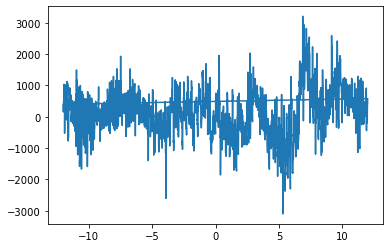

In [140]:
# plot random fft
sig = b.iloc[1000]
N = len(sig)
t = np.linspace(0, N*1/24, N)

sp = np.fft.fft(sig)
freq = np.fft.fftfreq(len(t), d=1/24)

plt.plot(freq, sp.real)

In [141]:
# aggregation can be used to calculate multiple functions

In [48]:
%%time

df.groupby("ids").ve.agg([np.max, np.min, np.mean, np.std])

CPU times: user 4.07 s, sys: 1.68 s, total: 5.76 s
Wall time: 6.47 s


,amax,amin,mean,std
ids,,,,
2578,1.3912,-1.0212,0.016376,0.302970
2582,0.6155,-0.8061,-0.010888,0.143363
2583,0.2733,-0.2443,0.014034,0.090755
2592,0.2980,-0.3424,-0.030997,0.090660
2612,0.7094,-0.6637,-0.007169,0.123428
...,...,...,...,...
68249260,0.3671,-0.3286,0.006862,0.114108
68310100,0.4613,-0.6490,-0.019923,0.140866
68313240,0.5543,-0.5136,-0.004290,0.148957
